# Microsoft Malware detection

In [3]:
import warnings
warnings.filterwarnings("ignore")
import shutil
import os
import pandas as pd
import matplotlib
matplotlib.use(u'nbAgg')
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import sparse
import numpy as np
import pickle
from sklearn.manifold import TSNE
from sklearn import preprocessing
import pandas as pd
from multiprocessing import Process# this is used for multithreading
import multiprocessing
import codecs# this is used for file operations 
import random as r
from xgboost import XGBClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
%matplotlib inline

In [2]:
#separating byte files and asm files 

source = 'train'
destination_1 = 'byteFiles'
destination_2 = 'asmFiles'

# we will check if the folder 'byteFiles' exists if it not there we will create a folder with the same name
if not os.path.isdir(destination_1):
    os.makedirs(destination_1)
if not os.path.isdir(destination_2):
    os.makedirs(destination_2)

# if we have folder called 'train' (train folder contains both .asm files and .bytes files) we will rename it 'asmFiles'
# for every file that we have in our 'asmFiles' directory we check if it is ending with .bytes, if yes we will move it to
# 'byteFiles' folder

# so by the end of this snippet we will separate all the .byte files and .asm files
if os.path.isdir(source):
    data_files = os.listdir(source)
    for file in data_files:
        #print(file)
        if (file.endswith("bytes")):
            shutil.move(source+'/'+file,destination_1)
        if (file.endswith("asm")):
            shutil.move(source+'/'+file,destination_2)

<h2>Distribution of malware classes in whole data set </h2>

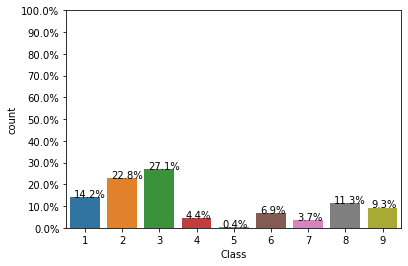

In [3]:
Y=pd.read_csv("trainLabels.csv")
total = len(Y)*1.
ax=sns.countplot(x="Class", data=Y)
for p in ax.patches:
        ax.annotate('{:.1f}%'.format(100*p.get_height()/total), (p.get_x()+0.1, p.get_height()+5))

#put 11 ticks (therefore 10 steps), from 0 to the total number of rows in the dataframe
ax.yaxis.set_ticks(np.linspace(0, total, 11))

#adjust the ticklabel to the desired format, without changing the position of the ticks. 
ax.set_yticklabels(map('{:.1f}%'.format, 100*ax.yaxis.get_majorticklocs()/total))
plt.show()

<h2>Feature extraction </h2>

<h3>1. File size  of byte files as a feature </h3>

In [4]:
#file sizes of byte files

files=os.listdir('byteFiles')
filenames=Y['Id'].tolist()
class_y=Y['Class'].tolist()
class_bytes=[]
sizebytes=[]
fnames=[]
for file in files:
    # print(os.stat('byteFiles/0A32eTdBKayjCWhZqDOQ.txt'))
    # os.stat_result(st_mode=33206, st_ino=1125899906874507, st_dev=3561571700, st_nlink=1, st_uid=0, st_gid=0, 
    # st_size=3680109, st_atime=1519638522, st_mtime=1519638522, st_ctime=1519638522)
    # read more about os.stat: here https://www.tutorialspoint.com/python/os_stat.htm
    statinfo=os.stat('byteFiles/'+file)
    # split the file name at '.' and take the first part of it i.e the file name
    file=file.split('.')[0]
    if any(file == filename for filename in filenames):
        i=filenames.index(file)
        class_bytes.append(class_y[i])
        # converting into Mb's
        sizebytes.append(statinfo.st_size/(1024.0*1024.0))
        fnames.append(file)
data_size_byte=pd.DataFrame({'ID':fnames,'size':sizebytes,'Class':class_bytes})
print (data_size_byte.head())

                     ID      size  Class
0  1NSfFQ28b0TDh5YGnLeR  0.925781      8
1  bMzad2EXxSlq1ftBj5UK  1.488281      1
2  8HEiC2mz6tVxPqD4QhlG  0.644531      6
3  hK7qMc3ZHmF5e4bLfCOj  0.785156      1
4  5mTjuSpdDG8k1IBHaPqY  4.207031      7


<h3>2. box plots of file size (.byte files) feature </h3>

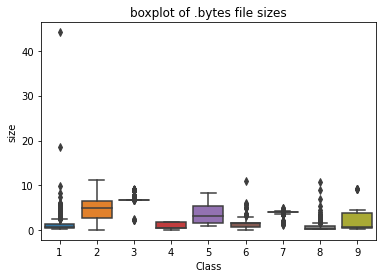

In [5]:
#boxplot of byte files
ax = sns.boxplot(x="Class", y="size", data=data_size_byte)
plt.title("boxplot of .bytes file sizes")
plt.show()

<h3>3. feature extraction from byte files </h3>

In [2]:
#removal of addres from byte files
# contents of .byte files
# ----------------
#00401000 56 8D 44 24 08 50 8B F1 E8 1C 1B 00 00 C7 06 08 
#-------------------
#we remove the starting address 00401000
files = os.listdir('byteFiles')
filenames=[]
array=[]
for file in files:
    if(file.endswith("bytes")):
        file=file.split('.')[0]
        text_file = open('byteFiles/'+file+".txt", 'w+')
        with open('byteFiles/'+file+".bytes","r") as fp:
            lines=""
            for line in fp:
                a=line.rstrip().split(" ")[1:]
                b=' '.join(a)
                b=b+"\n"
                text_file.write(b)
            fp.close()
            os.remove('byteFiles/'+file+".bytes")
        text_file.close()

files = os.listdir('byteFiles')
filenames2=[]



## 4. Binary Bag of Words Feature Creation

In [3]:
#bigrams featurization

hexa='0,1,2,3,4,5,6,7,8,9,a,b,c,d,e,f'
unigrams=[]
for i in hexa.split(','):
    for j in hexa.split(','):
        unigrams.append(i+j)
unigrams.append('??')

bigrams = list()
for i in unigrams:
    for j in unigrams:
        bigrams.append(i + " "+ j)

In [4]:
files = os.listdir("byteFiles")

In [5]:
def bow(files, bigrams):

    feature_matrix = sparse.csr_matrix((len(files),66049))

    vec = CountVectorizer(vocabulary=bigrams, lowercase= False, ngram_range=(2,2))

    from tqdm import tqdm
    row = 0 

    ID_list = list()
    for file in tqdm(files):
        if(file.endswith("txt")):
            file=file.split('.')[0]
            #read the byte file
            with open('byteFiles/'+file+".txt","r") as fp:
                temp = vec.fit_transform([fp.read().replace("\n",' ')])
                feature_matrix[row,:] = temp
                row = row + 1
                ID_list.extend([file])
                #close the file
    return feature_matrix, ID_list

In [7]:
feature_matrix, ID_list = bow(files, bigrams)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 10868/10868 [8:03:42<00:00,  2.67s/it]


In [8]:
#train = feature_matrix[:int(.7*feature_matrix.shape[0])]
#test = feature_matrix[int(.7*feature_matrix.shape[0]):]

In [9]:
#with open('Byte_Features_ID_Sparse.pickle', 'wb') as f:
    #pickle.dump([feature_matrix, ID_list], f)

In [12]:
type(feature_matrix)

scipy.sparse.csr.csr_matrix

In [13]:
feature_matrix

<10868x66049 sparse matrix of type '<class 'numpy.float64'>'
	with 81281518 stored elements in Compressed Sparse Row format>

In [22]:
import pickle

with open('Byte_Features_ID_Sparse.pickle', 'rb') as f:
    feature_matrix, ID_list = pickle.load(f)

In [23]:
feature_matrix.size

81281518

In [4]:
len(ID_list)

10868

In [5]:
Y = pd.read_csv('trainLabels.csv')
filenames = Y['Id'].tolist()
class_y = Y['Class'].tolist()

index = class_bytes = sizebytes = fnames = list()

for ID in ID_list:
    index.append(filenames.index(ID))



In [6]:
Y['index'] = index

In [8]:
Y.columns

Index(['Id', 'Class', 'index'], dtype='object')

In [9]:
Y.head()

,Id,Class,index
0,01kcPWA9K2BOxQeS5Rju,1,8694
1,04EjIdbPV5e1XroFOpiN,1,657
2,05EeG39MTRrI6VY21DPd,1,7684
3,05rJTUWYAKNegBk2wE8X,1,1252
4,0AnoOZDNbPXIr2MRBSCJ,1,8289


In [10]:
Y = Y.sort_values('index').reset_index()

In [11]:
Y.head(10)

,level_0,Id,Class,index
0,9722,iUQAHhE3TKRjagWtFdJk,8,0
1,1807,3AVbapKO2BYJTqtfMv5P,2,1
2,5151,asK0HpjZeJCPf6kXDbzx,3,2
3,8575,jhgdqC2e1Z4inImTQKvY,7,3
4,2035,6cJ4OV1TGifn92SCPNEA,2,4
5,7533,2FpVtbaHJWAG0ImwTzxU,6,5
6,1664,1KjwODdhC3VxA4MSLbFI,2,6
7,5919,ENAgb4Hf0pzKyqG5Xjrl,3,7
8,7882,dN8OJEu9iqsXotfPkaDT,6,8
9,1803,39VK5R6xNtwkBZqDY7Lr,2,9


In [12]:
Y.drop(['index', 'level_0'], axis = 1, inplace = True)

In [13]:
Y.head(5)

,Id,Class
0,iUQAHhE3TKRjagWtFdJk,8
1,3AVbapKO2BYJTqtfMv5P,2
2,asK0HpjZeJCPf6kXDbzx,3
3,jhgdqC2e1Z4inImTQKvY,7
4,6cJ4OV1TGifn92SCPNEA,2


In [14]:
import pickle

#with open('Byte_Features_ID_Y_Sparse.pickle', 'wb') as f:
    #pickle.dump([feature_matrix, ID_list, Y], f)

In [15]:
with open('Byte_Features_ID_Y_Sparse.pickle', 'rb') as f:
    feature_matrix, ID_list, Y = pickle.load(f)

# Train Test split

In [16]:
data_y = Y['Class']
# split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
X_train, X_test, y_train, y_test = train_test_split(feature_matrix, data_y, stratify=data_y, test_size=0.20)
# split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, stratify=y_train, test_size=0.20)

In [17]:
#with open('train_test_split.pickle', 'wb') as f:
    #pickle.dump([X_train, X_test, X_cv, y_train, y_test, y_cv], f)

In [18]:
with open('train_test_split.pickle', 'rb') as f:
    X_train, X_test, X_cv, y_train, y_test, y_cv = pickle.load(f)

In [19]:
print('Number of data points in train data:', X_train.shape[0])
print('Number of data points in test data:', X_test.shape[0])
print('Number of data points in cross validation data:', X_cv.shape[0])

Number of data points in train data: 6955
Number of data points in test data: 2174
Number of data points in cross validation data: 1739


In [4]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    print("Number of misclassified points ",(len(test_y)-np.trace(C))/len(test_y)*100)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    
    labels = [1,2,3,4,5,6,7,8,9]
    cmap=sns.light_palette("green")
    # representing A in heatmap format
    print("-"*50, "Confusion matrix", "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()

    print("-"*50, "Precision matrix", "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of columns in precision matrix",B.sum(axis=0))
    
    # representing B in heatmap format
    print("-"*50, "Recall matrix"    , "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of rows in precision matrix",A.sum(axis=1))

<h1>4. Machine Learning Models</h1>

<h2>4.1. Machine Leaning Models on bytes files</h2>

<h3>4.1.1. Random Model</h3>

Log loss on Cross Validation Data using Random Model 2.5014838641815644
Log loss on Test Data using Random Model 2.467407921101908
Number of misclassified points  88.86844526218951
-------------------------------------------------- Confusion matrix --------------------------------------------------


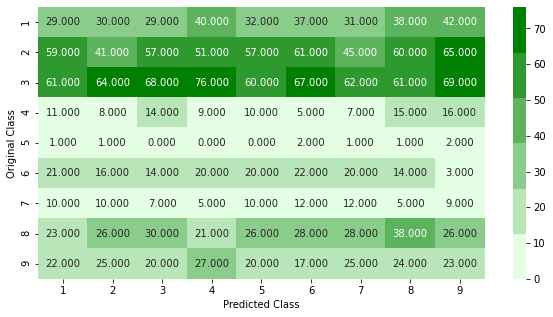

-------------------------------------------------- Precision matrix --------------------------------------------------


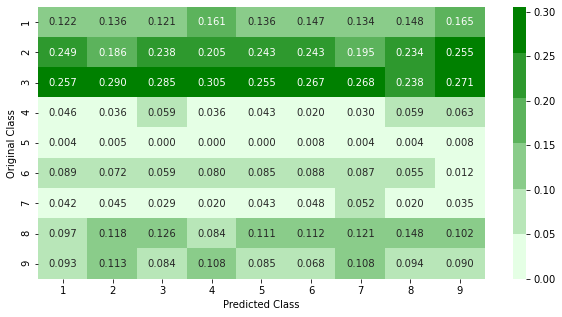

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


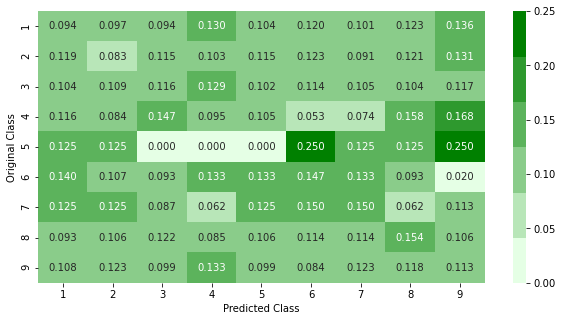

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [5]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039

test_data_len = X_test.shape[0]
cv_data_len = X_cv.shape[0]

# we create a output array that has exactly same size as the CV data
cv_predicted_y = np.zeros((cv_data_len,9))
for i in range(cv_data_len):
    rand_probs = np.random.rand(1,9)
    cv_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Cross Validation Data using Random Model",log_loss(y_cv,cv_predicted_y, eps=1e-15))


# Test-Set error.
#we create a output array that has exactly same as the test data
test_predicted_y = np.zeros((test_data_len,9))
for i in range(test_data_len):
    rand_probs = np.random.rand(1,9)
    test_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test,test_predicted_y, eps=1e-15))

predicted_y =np.argmax(test_predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y+1)

<h3>4.1.2. K Nearest Neighbour Classification</h3>

log_loss for k =  1 is 1.8990633527428111
log_loss for k =  3 is 1.9013334952389367
log_loss for k =  5 is 1.9000433639616614
log_loss for k =  7 is 1.900379298153243
log_loss for k =  9 is 1.900239205104143
log_loss for k =  11 is 1.899824268744998
log_loss for k =  13 is 1.899561006179157


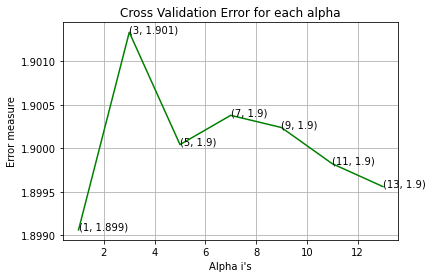

For values of best alpha =  1 The train log loss is: 1.8694712827927724
For values of best alpha =  1 The cross validation log loss is: 1.8990633527428111
For values of best alpha =  1 The test log loss is: 1.9003103946176672
Number of misclassified points  72.95308187672494
-------------------------------------------------- Confusion matrix --------------------------------------------------


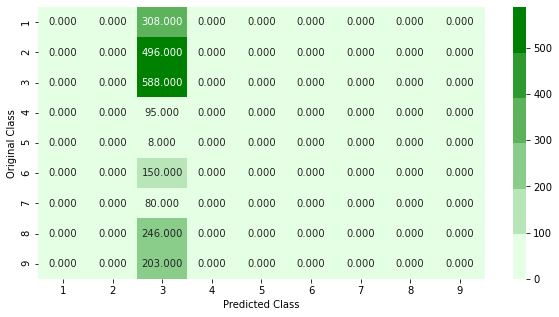

-------------------------------------------------- Precision matrix --------------------------------------------------


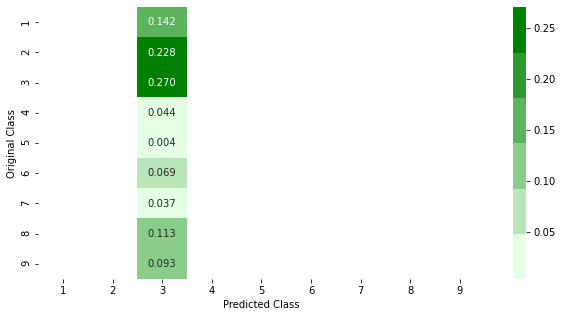

Sum of columns in precision matrix [nan nan  1. nan nan nan nan nan nan]
-------------------------------------------------- Recall matrix --------------------------------------------------


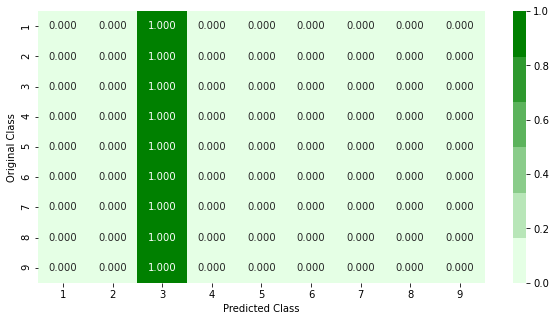

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [5]:
# find more about KNeighborsClassifier() here http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
# -------------------------
# default parameter
# KNeighborsClassifier(n_neighbors=5, weights=’uniform’, algorithm=’auto’, leaf_size=30, p=2, 
# metric=’minkowski’, metric_params=None, n_jobs=1, **kwargs)

# methods of
# fit(X, y) : Fit the model using X as training data and y as target values
# predict(X):Predict the class labels for the provided data
# predict_proba(X):Return probability estimates for the test data X.
#-------------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/k-nearest-neighbors-geometric-intuition-with-a-toy-example-1/
#-------------------------------------


# find more about CalibratedClassifierCV here at http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
# ----------------------------
# default paramters
# sklearn.calibration.CalibratedClassifierCV(base_estimator=None, method=’sigmoid’, cv=3)
#
# some of the methods of CalibratedClassifierCV()
# fit(X, y[, sample_weight])	Fit the calibrated model
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict the target of new samples.
# predict_proba(X)	Posterior probabilities of classification
#-------------------------------------
# video link:
#-------------------------------------
  
alpha = [x for x in range(1, 15, 2)]
cv_log_error_array=[]
for i in alpha:
    k_cfl=KNeighborsClassifier(n_neighbors=i)
    k_cfl.fit(X_train,y_train)
    sig_clf = CalibratedClassifierCV(k_cfl, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_cv)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=k_cfl.classes_, eps=1e-15))
    
for i in range(len(cv_log_error_array)):
    print ('log_loss for k = ',alpha[i],'is',cv_log_error_array[i])

best_alpha = np.argmin(cv_log_error_array)
    
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

k_cfl=KNeighborsClassifier(n_neighbors=alpha[best_alpha])
k_cfl.fit(X_train,y_train)
sig_clf = CalibratedClassifierCV(k_cfl, method="sigmoid")
sig_clf.fit(X_train, y_train)
    
predict_y = sig_clf.predict_proba(X_train)
print ('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y))
predict_y = sig_clf.predict_proba(X_cv)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y))
plot_confusion_matrix(y_test, sig_clf.predict(X_test))

<h3>4.1.3. Logistic Regression</h3>

log_loss for c =  1e-05 is 1.900611110802529
log_loss for c =  0.0001 is 1.9007524731829493
log_loss for c =  0.001 is 1.900360926919982
log_loss for c =  0.01 is 1.90045102229466
log_loss for c =  0.1 is 1.9004326039240995
log_loss for c =  1 is 1.9004868588583972
log_loss for c =  10 is 1.9004444132114728
log_loss for c =  100 is 1.9004163852187392
log_loss for c =  1000 is 1.9004240870515947


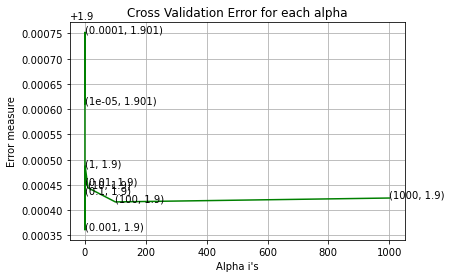

log loss for train data 1.892172622138733
log loss for cv data 1.900360926919982
log loss for test data 1.900189389701887
Number of misclassified points  72.99908003679853
-------------------------------------------------- Confusion matrix --------------------------------------------------


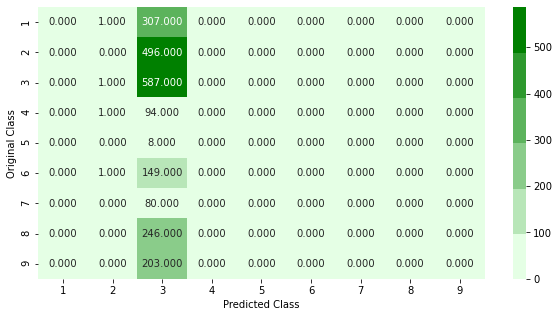

-------------------------------------------------- Precision matrix --------------------------------------------------


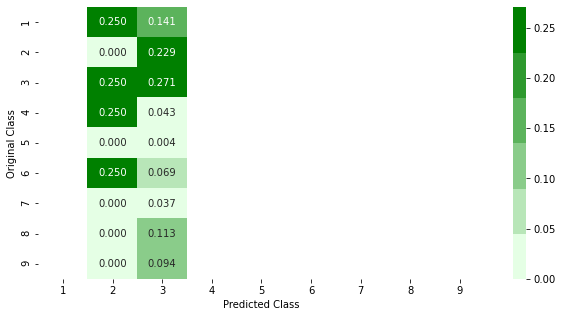

Sum of columns in precision matrix [nan  1.  1. nan nan nan nan nan nan]
-------------------------------------------------- Recall matrix --------------------------------------------------


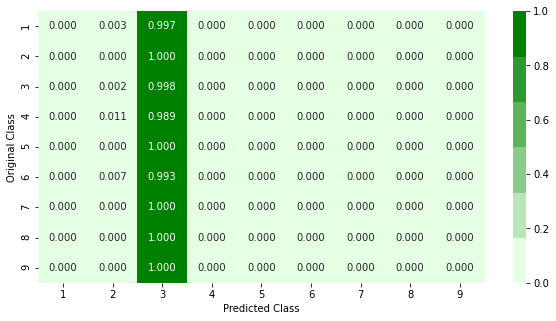

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [5]:
# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/geometric-intuition-1/
#------------------------------

alpha = [10 ** x for x in range(-5, 4)]
cv_log_error_array=[]
for i in alpha:
    logisticR=LogisticRegression(penalty='l2',C=i,class_weight='balanced')
    logisticR.fit(X_train,y_train)
    sig_clf = CalibratedClassifierCV(logisticR, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_cv)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=logisticR.classes_, eps=1e-15))
    
for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])

best_alpha = np.argmin(cv_log_error_array)
    
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

logisticR=LogisticRegression(penalty='l2',C=alpha[best_alpha],class_weight='balanced')
logisticR.fit(X_train,y_train)
sig_clf = CalibratedClassifierCV(logisticR, method="sigmoid")
sig_clf.fit(X_train, y_train)
pred_y=sig_clf.predict(X_test)

predict_y = sig_clf.predict_proba(X_train)
print ('log loss for train data',log_loss(y_train, predict_y, labels=logisticR.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_cv)
print ('log loss for cv data',log_loss(y_cv, predict_y, labels=logisticR.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print ('log loss for test data',log_loss(y_test, predict_y, labels=logisticR.classes_, eps=1e-15))
plot_confusion_matrix(y_test, sig_clf.predict(X_test))

<h3> 4.1.4. Random Forest Classifier </h3>

log_loss for c =  10 is 1.9004392269134638
log_loss for c =  50 is 1.9006496499237526
log_loss for c =  100 is 1.9008882938034821
log_loss for c =  500 is 1.9002482481076766
log_loss for c =  1000 is 1.9001879077699901
log_loss for c =  2000 is 1.8999908731969897
log_loss for c =  3000 is 1.8999984683102797


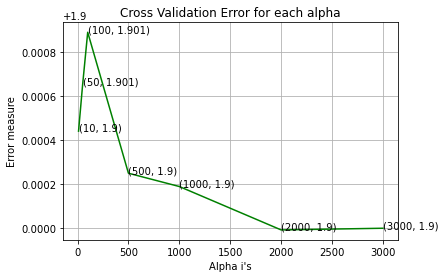

For values of best alpha =  2000 The train log loss is: 1.8029519480957716
For values of best alpha =  2000 The cross validation log loss is: 1.8999908731969897
For values of best alpha =  2000 The test log loss is: 1.8999280379424075
Number of misclassified points  72.95308187672494
-------------------------------------------------- Confusion matrix --------------------------------------------------


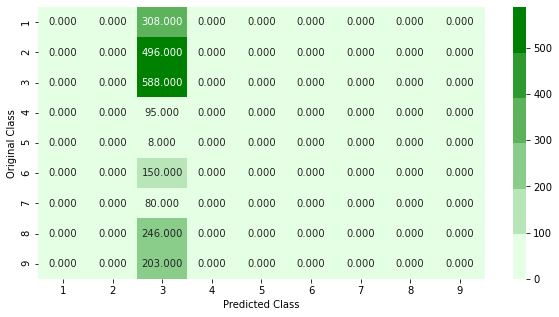

-------------------------------------------------- Precision matrix --------------------------------------------------


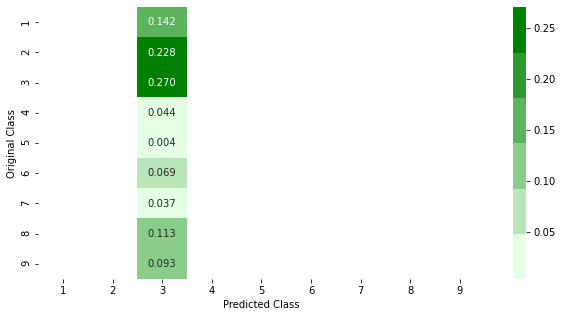

Sum of columns in precision matrix [nan nan  1. nan nan nan nan nan nan]
-------------------------------------------------- Recall matrix --------------------------------------------------


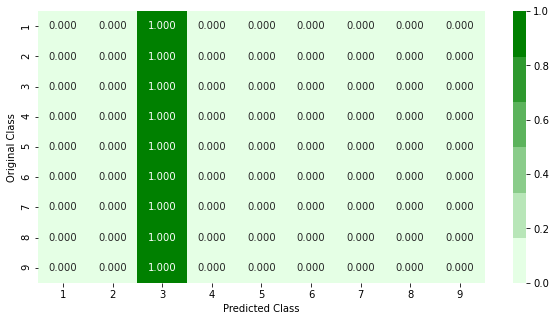

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [5]:
# --------------------------------
# default parameters 
# sklearn.ensemble.RandomForestClassifier(n_estimators=10, criterion=’gini’, max_depth=None, min_samples_split=2, 
# min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=’auto’, max_leaf_nodes=None, min_impurity_decrease=0.0, 
# min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=1, random_state=None, verbose=0, warm_start=False, 
# class_weight=None)

# Some of methods of RandomForestClassifier()
# fit(X, y, [sample_weight])	Fit the SVM model according to the given training data.
# predict(X)	Perform classification on samples in X.
# predict_proba (X)	Perform classification on samples in X.

# some of attributes of  RandomForestClassifier()
# feature_importances_ : array of shape = [n_features]
# The feature importances (the higher, the more important the feature).

# --------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/random-forest-and-their-construction-2/
# --------------------------------

alpha=[10,50,100,500,1000,2000,3000]
cv_log_error_array=[]
train_log_error_array=[]
from sklearn.ensemble import RandomForestClassifier
for i in alpha:
    r_cfl=RandomForestClassifier(n_estimators=i,random_state=42,n_jobs=-1)
    r_cfl.fit(X_train,y_train)
    sig_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_cv)
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=r_cfl.classes_, eps=1e-15))

for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])


best_alpha = np.argmin(cv_log_error_array)

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


r_cfl=RandomForestClassifier(n_estimators=alpha[best_alpha],random_state=42,n_jobs=-1)
r_cfl.fit(X_train,y_train)
sig_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y))
predict_y = sig_clf.predict_proba(X_cv)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y))
plot_confusion_matrix(y_test, sig_clf.predict(X_test))

<h3>4.1.5. XgBoost Classification with best hyper parameters using RandomSearch </h3>

In [5]:
# https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
x_cfl=XGBClassifier()

prams={
    'learning_rate':[0.01,0.03,0.05,0.1,0.15,0.2],
     'n_estimators':[100,200,500,1000,2000],
     'max_depth':[3,5,10],
    'colsample_bytree':[0.1,0.3,0.5,1],
    'subsample':[0.1,0.3,0.5,1]
}
random_cfl1=RandomizedSearchCV(x_cfl,param_distributions=prams,verbose=10,n_jobs=-1,)
random_cfl1.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed: 48.1min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed: 163.9min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 275.5min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 344.3min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 401.2min
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed: 557.5min remaining: 122.4min
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed: 798.0min remaining: 50.9min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 803.3min finished


RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_job...
                                           random_state=None, reg_alpha=None,
                                           reg_lambda=None,
                                           scale_pos_weight=No

In [6]:
print (random_cfl1.best_params_)

{'subsample': 0.5, 'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.01, 'colsample_bytree': 0.1}


In [7]:
# Training a hyper-parameter tuned Xg-Boost regressor on our train data

# find more about XGBClassifier function here http://xgboost.readthedocs.io/en/latest/python/python_api.html?#xgboost.XGBClassifier
# -------------------------
# default paramters
# class xgboost.XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=100, silent=True, 
# objective='binary:logistic', booster='gbtree', n_jobs=1, nthread=None, gamma=0, min_child_weight=1, 
# max_delta_step=0, subsample=1, colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, 
# scale_pos_weight=1, base_score=0.5, random_state=0, seed=None, missing=None, **kwargs)

# some of methods of RandomForestRegressor()
# fit(X, y, sample_weight=None, eval_set=None, eval_metric=None, early_stopping_rounds=None, verbose=True, xgb_model=None)
# get_params([deep])	Get parameters for this estimator.
# predict(data, output_margin=False, ntree_limit=0) : Predict with data. NOTE: This function is not thread safe.
# get_score(importance_type='weight') -> get the feature importance
# -----------------------
# video link2: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/what-are-ensembles/
# -----------------------

x_cfl=XGBClassifier(n_estimators=2000, learning_rate=0.05, colsample_bytree=1, max_depth=3)
x_cfl.fit(X_train,y_train)
c_cfl=CalibratedClassifierCV(x_cfl,method='sigmoid')
c_cfl.fit(X_train,y_train)

predict_y = c_cfl.predict_proba(X_train)
print ('train loss',log_loss(y_train, predict_y))
predict_y = c_cfl.predict_proba(X_cv)
print ('cv loss',log_loss(y_cv, predict_y))
predict_y = c_cfl.predict_proba(X_test)
print ('test loss',log_loss(y_test, predict_y))

train loss 1.9415521175236334
cv loss 1.9013130495834594
test loss 1.8989823364049017


<h2> 4.2 Modeling with .asm files </h2>

<pre>
There are 10868 files of asm 
All the files make up about 150 GB
The asm files contains :
1. Address
2. Segments
3. Opcodes
4. Registers
5. function calls
6. APIs
With the help of parallel processing we extracted all the features.In parallel we can use all the cores that are present in our computer.


Here we extracted 52 features from all the asm files which are important.

We read the top solutions and handpicked the features from those papers/videos/blogs. <br> Refer:https://www.kaggle.com/c/malware-classification/discussion
</pre>

<h3> 4.2.1 Feature extraction from asm files </h3>

<p>
<li> To extract the unigram features from the .asm files we need to process ~150GB of data </li>
<li style="font-size:18px"><b>Note: Below two cells will take lot of time (over 48 hours to complete)</b></li>
<li> We will provide you the output file of these two cells, which you can directly use it </li>
</p>

In [ ]:
#intially create five folders
#first 
#second
#thrid
#fourth
#fifth
#this code tells us about random split of files into five folders
folder_1 ='first'
folder_2 ='second'
folder_3 ='third'
folder_4 ='fourth'
folder_5 ='fifth'
folder_6 = 'output'
for i in [folder_1,folder_2,folder_3,folder_4,folder_5,folder_6]:
    if not os.path.isdir(i):
        os.makedirs(i)

source='train/'
files = os.listdir('train')
ID=df['Id'].tolist()
data=range(0,10868)
r.shuffle(data)
count=0
for i in range(0,10868):
    if i % 5==0:
        shutil.move(source+files[data[i]],'first')
    elif i%5==1:
        shutil.move(source+files[data[i]],'second')
    elif i%5 ==2:
        shutil.move(source+files[data[i]],'thrid')
    elif i%5 ==3:
        shutil.move(source+files[data[i]],'fourth')
    elif i%5==4:
        shutil.move(source+files[data[i]],'fifth')

In [ ]:

#http://flint.cs.yale.edu/cs421/papers/x86-asm/asm.html

def firstprocess():
    #The prefixes tells about the segments that are present in the asm files
    #There are 450 segments(approx) present in all asm files.
    #this prefixes are best segments that gives us best values.
    #https://en.wikipedia.org/wiki/Data_segment
    
    prefixes = ['HEADER:','.text:','.Pav:','.idata:','.data:','.bss:','.rdata:','.edata:','.rsrc:','.tls:','.reloc:','.BSS:','.CODE']
    #this are opcodes that are used to get best results
    #https://en.wikipedia.org/wiki/X86_instruction_listings
    
    opcodes = ['jmp', 'mov', 'retf', 'push', 'pop', 'xor', 'retn', 'nop', 'sub', 'inc', 'dec', 'add','imul', 'xchg', 'or', 'shr', 'cmp', 'call', 'shl', 'ror', 'rol', 'jnb','jz','rtn','lea','movzx']
    #best keywords that are taken from different blogs
    keywords = ['.dll','std::',':dword']
    #Below taken registers are general purpose registers and special registers
    #All the registers which are taken are best 
    registers=['edx','esi','eax','ebx','ecx','edi','ebp','esp','eip']
    file1=open("output\asmsmallfile.txt","w+")
    files = os.listdir('first')
    for f in files:
        #filling the values with zeros into the arrays
        prefixescount=np.zeros(len(prefixes),dtype=int)
        opcodescount=np.zeros(len(opcodes),dtype=int)
        keywordcount=np.zeros(len(keywords),dtype=int)
        registerscount=np.zeros(len(registers),dtype=int)
        features=[]
        f2=f.split('.')[0]
        file1.write(f2+",")
        opcodefile.write(f2+" ")
        # https://docs.python.org/3/library/codecs.html#codecs.ignore_errors
        # https://docs.python.org/3/library/codecs.html#codecs.Codec.encode
        with codecs.open('first/'+f,encoding='cp1252',errors ='replace') as fli:
            for lines in fli:
                # https://www.tutorialspoint.com/python3/string_rstrip.htm
                line=lines.rstrip().split()
                l=line[0]
                #counting the prefixs in each and every line
                for i in range(len(prefixes)):
                    if prefixes[i] in line[0]:
                        prefixescount[i]+=1
                line=line[1:]
                #counting the opcodes in each and every line
                for i in range(len(opcodes)):
                    if any(opcodes[i]==li for li in line):
                        features.append(opcodes[i])
                        opcodescount[i]+=1
                #counting registers in the line
                for i in range(len(registers)):
                    for li in line:
                        # we will use registers only in 'text' and 'CODE' segments
                        if registers[i] in li and ('text' in l or 'CODE' in l):
                            registerscount[i]+=1
                #counting keywords in the line
                for i in range(len(keywords)):
                    for li in line:
                        if keywords[i] in li:
                            keywordcount[i]+=1
        #pushing the values into the file after reading whole file
        for prefix in prefixescount:
            file1.write(str(prefix)+",")
        for opcode in opcodescount:
            file1.write(str(opcode)+",")
        for register in registerscount:
            file1.write(str(register)+",")
        for key in keywordcount:
            file1.write(str(key)+",")
        file1.write("\n")
    file1.close()


#same as above 
def secondprocess():
    prefixes = ['HEADER:','.text:','.Pav:','.idata:','.data:','.bss:','.rdata:','.edata:','.rsrc:','.tls:','.reloc:','.BSS:','.CODE']
    opcodes = ['jmp', 'mov', 'retf', 'push', 'pop', 'xor', 'retn', 'nop', 'sub', 'inc', 'dec', 'add','imul', 'xchg', 'or', 'shr', 'cmp', 'call', 'shl', 'ror', 'rol', 'jnb','jz','rtn','lea','movzx']
    keywords = ['.dll','std::',':dword']
    registers=['edx','esi','eax','ebx','ecx','edi','ebp','esp','eip']
    file1=open("output\mediumasmfile.txt","w+")
    files = os.listdir('second')
    for f in files:
        prefixescount=np.zeros(len(prefixes),dtype=int)
        opcodescount=np.zeros(len(opcodes),dtype=int)
        keywordcount=np.zeros(len(keywords),dtype=int)
        registerscount=np.zeros(len(registers),dtype=int)
        features=[]
        f2=f.split('.')[0]
        file1.write(f2+",")
        opcodefile.write(f2+" ")
        with codecs.open('second/'+f,encoding='cp1252',errors ='replace') as fli:
            for lines in fli:
                line=lines.rstrip().split()
                l=line[0]
                for i in range(len(prefixes)):
                    if prefixes[i] in line[0]:
                        prefixescount[i]+=1
                line=line[1:]
                for i in range(len(opcodes)):
                    if any(opcodes[i]==li for li in line):
                        features.append(opcodes[i])
                        opcodescount[i]+=1
                for i in range(len(registers)):
                    for li in line:
                        if registers[i] in li and ('text' in l or 'CODE' in l):
                            registerscount[i]+=1
                for i in range(len(keywords)):
                    for li in line:
                        if keywords[i] in li:
                            keywordcount[i]+=1
        for prefix in prefixescount:
            file1.write(str(prefix)+",")
        for opcode in opcodescount:
            file1.write(str(opcode)+",")
        for register in registerscount:
            file1.write(str(register)+",")
        for key in keywordcount:
            file1.write(str(key)+",")
        file1.write("\n")
    file1.close()

# same as smallprocess() functions
def thirdprocess():
    prefixes = ['HEADER:','.text:','.Pav:','.idata:','.data:','.bss:','.rdata:','.edata:','.rsrc:','.tls:','.reloc:','.BSS:','.CODE']
    opcodes = ['jmp', 'mov', 'retf', 'push', 'pop', 'xor', 'retn', 'nop', 'sub', 'inc', 'dec', 'add','imul', 'xchg', 'or', 'shr', 'cmp', 'call', 'shl', 'ror', 'rol', 'jnb','jz','rtn','lea','movzx']
    keywords = ['.dll','std::',':dword']
    registers=['edx','esi','eax','ebx','ecx','edi','ebp','esp','eip']
    file1=open("output\largeasmfile.txt","w+")
    files = os.listdir('thrid')
    for f in files:
        prefixescount=np.zeros(len(prefixes),dtype=int)
        opcodescount=np.zeros(len(opcodes),dtype=int)
        keywordcount=np.zeros(len(keywords),dtype=int)
        registerscount=np.zeros(len(registers),dtype=int)
        features=[]
        f2=f.split('.')[0]
        file1.write(f2+",")
        opcodefile.write(f2+" ")
        with codecs.open('thrid/'+f,encoding='cp1252',errors ='replace') as fli:
            for lines in fli:
                line=lines.rstrip().split()
                l=line[0]
                for i in range(len(prefixes)):
                    if prefixes[i] in line[0]:
                        prefixescount[i]+=1
                line=line[1:]
                for i in range(len(opcodes)):
                    if any(opcodes[i]==li for li in line):
                        features.append(opcodes[i])
                        opcodescount[i]+=1
                for i in range(len(registers)):
                    for li in line:
                        if registers[i] in li and ('text' in l or 'CODE' in l):
                            registerscount[i]+=1
                for i in range(len(keywords)):
                    for li in line:
                        if keywords[i] in li:
                            keywordcount[i]+=1
        for prefix in prefixescount:
            file1.write(str(prefix)+",")
        for opcode in opcodescount:
            file1.write(str(opcode)+",")
        for register in registerscount:
            file1.write(str(register)+",")
        for key in keywordcount:
            file1.write(str(key)+",")
        file1.write("\n")
    file1.close()


def fourthprocess():
    prefixes = ['HEADER:','.text:','.Pav:','.idata:','.data:','.bss:','.rdata:','.edata:','.rsrc:','.tls:','.reloc:','.BSS:','.CODE']
    opcodes = ['jmp', 'mov', 'retf', 'push', 'pop', 'xor', 'retn', 'nop', 'sub', 'inc', 'dec', 'add','imul', 'xchg', 'or', 'shr', 'cmp', 'call', 'shl', 'ror', 'rol', 'jnb','jz','rtn','lea','movzx']
    keywords = ['.dll','std::',':dword']
    registers=['edx','esi','eax','ebx','ecx','edi','ebp','esp','eip']
    file1=open("output\hugeasmfile.txt","w+")
    files = os.listdir('fourth/')
    for f in files:
        prefixescount=np.zeros(len(prefixes),dtype=int)
        opcodescount=np.zeros(len(opcodes),dtype=int)
        keywordcount=np.zeros(len(keywords),dtype=int)
        registerscount=np.zeros(len(registers),dtype=int)
        features=[]
        f2=f.split('.')[0]
        file1.write(f2+",")
        opcodefile.write(f2+" ")
        with codecs.open('fourth/'+f,encoding='cp1252',errors ='replace') as fli:
            for lines in fli:
                line=lines.rstrip().split()
                l=line[0]
                for i in range(len(prefixes)):
                    if prefixes[i] in line[0]:
                        prefixescount[i]+=1
                line=line[1:]
                for i in range(len(opcodes)):
                    if any(opcodes[i]==li for li in line):
                        features.append(opcodes[i])
                        opcodescount[i]+=1
                for i in range(len(registers)):
                    for li in line:
                        if registers[i] in li and ('text' in l or 'CODE' in l):
                            registerscount[i]+=1
                for i in range(len(keywords)):
                    for li in line:
                        if keywords[i] in li:
                            keywordcount[i]+=1
        for prefix in prefixescount:
            file1.write(str(prefix)+",")
        for opcode in opcodescount:
            file1.write(str(opcode)+",")
        for register in registerscount:
            file1.write(str(register)+",")
        for key in keywordcount:
            file1.write(str(key)+",")
        file1.write("\n")
    file1.close()


def fifthprocess():
    prefixes = ['HEADER:','.text:','.Pav:','.idata:','.data:','.bss:','.rdata:','.edata:','.rsrc:','.tls:','.reloc:','.BSS:','.CODE']
    opcodes = ['jmp', 'mov', 'retf', 'push', 'pop', 'xor', 'retn', 'nop', 'sub', 'inc', 'dec', 'add','imul', 'xchg', 'or', 'shr', 'cmp', 'call', 'shl', 'ror', 'rol', 'jnb','jz','rtn','lea','movzx']
    keywords = ['.dll','std::',':dword']
    registers=['edx','esi','eax','ebx','ecx','edi','ebp','esp','eip']
    file1=open("output\trainasmfile.txt","w+")
    files = os.listdir('fifth/')
    for f in files:
        prefixescount=np.zeros(len(prefixes),dtype=int)
        opcodescount=np.zeros(len(opcodes),dtype=int)
        keywordcount=np.zeros(len(keywords),dtype=int)
        registerscount=np.zeros(len(registers),dtype=int)
        features=[]
        f2=f.split('.')[0]
        file1.write(f2+",")
        opcodefile.write(f2+" ")
        with codecs.open('fifth/'+f,encoding='cp1252',errors ='replace') as fli:
            for lines in fli:
                line=lines.rstrip().split()
                l=line[0]
                for i in range(len(prefixes)):
                    if prefixes[i] in line[0]:
                        prefixescount[i]+=1
                line=line[1:]
                for i in range(len(opcodes)):
                    if any(opcodes[i]==li for li in line):
                        features.append(opcodes[i])
                        opcodescount[i]+=1
                for i in range(len(registers)):
                    for li in line:
                        if registers[i] in li and ('text' in l or 'CODE' in l):
                            registerscount[i]+=1
                for i in range(len(keywords)):
                    for li in line:
                        if keywords[i] in li:
                            keywordcount[i]+=1
        for prefix in prefixescount:
            file1.write(str(prefix)+",")
        for opcode in opcodescount:
            file1.write(str(opcode)+",")
        for register in registerscount:
            file1.write(str(register)+",")
        for key in keywordcount:
            file1.write(str(key)+",")
        file1.write("\n")
    file1.close()


def main():
    #the below code is used for multiprogramming
    #the number of process depends upon the number of cores present System
    #process is used to call multiprogramming
    manager=multiprocessing.Manager() 	
    p1=Process(target=firstprocess)
    p2=Process(target=secondprocess)
    p3=Process(target=thirdprocess)
    p4=Process(target=fourthprocess)
    p5=Process(target=fifthprocess)
    #p1.start() is used to start the thread execution
    p1.start()
    p2.start()
    p3.start()
    p4.start()
    p5.start()
    #After completion all the threads are joined
    p1.join()
    p2.join()
    p3.join()
    p4.join()
    p5.join()

if __name__=="__main__":
    main()

In [2]:
# asmoutputfile.csv(output genarated from the above two cells) will contain all the extracted features from .asm files
# this file will be uploaded in the drive, you can directly use this
dfasm=pd.read_csv("asmoutputfile.csv")
Y=pd.read_csv("trainLabels.csv")
Y.columns = ['ID', 'Class']
result_asm = pd.merge(dfasm, Y,on='ID', how='left')
result_asm.head()

,ID,HEADER:,.text:,.Pav:,.idata:,.data:,.bss:,.rdata:,.edata:,.rsrc:,...,edx,esi,eax,ebx,ecx,edi,ebp,esp,eip,Class
0,01kcPWA9K2BOxQeS5Rju,19,744,0,127,57,0,323,0,3,...,18,66,15,43,83,0,17,48,29,1
1,1E93CpP60RHFNiT5Qfvn,17,838,0,103,49,0,0,0,3,...,18,29,48,82,12,0,14,0,20,1
2,3ekVow2ajZHbTnBcsDfX,17,427,0,50,43,0,145,0,3,...,13,42,10,67,14,0,11,0,9,1
3,3X2nY7iQaPBIWDrAZqJe,17,227,0,43,19,0,0,0,3,...,6,8,14,7,2,0,8,0,6,1
4,46OZzdsSKDCFV8h7XWxf,17,402,0,59,170,0,0,0,3,...,12,9,18,29,5,0,11,0,11,1


In [3]:
# https://stackoverflow.com/a/29651514
def normalize(df):
    result1 = df.copy()
    for feature_name in df.columns:
        if (str(feature_name) != str('ID') and str(feature_name)!=str('Class')):
            max_value = df[feature_name].max()
            min_value = df[feature_name].min()
            result1[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result1

<h4> 4.2.1.1 Files sizes of each .asm file </h4>

In [4]:
#file sizes of byte files

files=os.listdir('asmFiles')
filenames=Y['ID'].tolist()
class_y=Y['Class'].tolist()
class_bytes=[]
sizebytes=[]
fnames=[]
for file in files:
    # print(os.stat('byteFiles/0A32eTdBKayjCWhZqDOQ.txt'))
    # os.stat_result(st_mode=33206, st_ino=1125899906874507, st_dev=3561571700, st_nlink=1, st_uid=0, st_gid=0, 
    # st_size=3680109, st_atime=1519638522, st_mtime=1519638522, st_ctime=1519638522)
    # read more about os.stat: here https://www.tutorialspoint.com/python/os_stat.htm
    statinfo=os.stat('asmFiles/'+file)
    # split the file name at '.' and take the first part of it i.e the file name
    file=file.split('.')[0]
    if any(file == filename for filename in filenames):
        i=filenames.index(file)
        class_bytes.append(class_y[i])
        # converting into Mb's
        sizebytes.append(statinfo.st_size/(1024.0*1024.0))
        fnames.append(file)
asm_size_byte=pd.DataFrame({'ID':fnames,'size':sizebytes,'Class':class_bytes})
print (asm_size_byte.head())

                     ID      size  Class
0  dBO4MNxb7AzLaoWpm9vC  2.768433      1
1  0cfIE39ihRNo2rkZOw5H  0.159820      3
2  BsLcIW6ren2ZUDX74Cbu  0.165640      7
3  0itbI5mjJF28ocTkrUf9  0.216739      3
4  BH56lpgQn32eUyJDFImv  0.915680      8


<h4> 4.2.1.2 Distribution of .asm file sizes</h4>

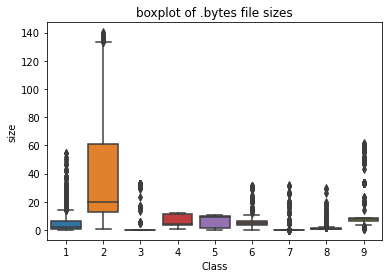

In [5]:
#boxplot of asm files
ax = sns.boxplot(x="Class", y="size", data=asm_size_byte)
plt.title("boxplot of .bytes file sizes")
plt.show()

In [6]:
# add the file size feature to previous extracted features
print(result_asm.shape)
print(asm_size_byte.shape)
result_asm = pd.merge(result_asm, asm_size_byte.drop(['Class'], axis=1),on='ID', how='left')
result_asm.head()

(10868, 53)
(10868, 3)


,ID,HEADER:,.text:,.Pav:,.idata:,.data:,.bss:,.rdata:,.edata:,.rsrc:,...,esi,eax,ebx,ecx,edi,ebp,esp,eip,Class,size
0,01kcPWA9K2BOxQeS5Rju,19,744,0,127,57,0,323,0,3,...,66,15,43,83,0,17,48,29,1,0.078190
1,1E93CpP60RHFNiT5Qfvn,17,838,0,103,49,0,0,0,3,...,29,48,82,12,0,14,0,20,1,0.063400
2,3ekVow2ajZHbTnBcsDfX,17,427,0,50,43,0,145,0,3,...,42,10,67,14,0,11,0,9,1,0.041695
3,3X2nY7iQaPBIWDrAZqJe,17,227,0,43,19,0,0,0,3,...,8,14,7,2,0,8,0,6,1,0.018757
4,46OZzdsSKDCFV8h7XWxf,17,402,0,59,170,0,0,0,3,...,9,18,29,5,0,11,0,11,1,0.037567


In [7]:
# we normalize the data each column 
result_asm = normalize(result_asm)
result_asm.head()

,ID,HEADER:,.text:,.Pav:,.idata:,.data:,.bss:,.rdata:,.edata:,.rsrc:,...,esi,eax,ebx,ecx,edi,ebp,esp,eip,Class,size
0,01kcPWA9K2BOxQeS5Rju,0.107345,0.001092,0.0,0.000761,0.000023,0.0,0.000084,0.0,0.000072,...,0.000746,0.000301,0.000360,0.001057,0.0,0.030797,0.001468,0.003173,1,0.000432
1,1E93CpP60RHFNiT5Qfvn,0.096045,0.001230,0.0,0.000617,0.000019,0.0,0.000000,0.0,0.000072,...,0.000328,0.000965,0.000686,0.000153,0.0,0.025362,0.000000,0.002188,1,0.000327
2,3ekVow2ajZHbTnBcsDfX,0.096045,0.000627,0.0,0.000300,0.000017,0.0,0.000038,0.0,0.000072,...,0.000475,0.000201,0.000560,0.000178,0.0,0.019928,0.000000,0.000985,1,0.000172
3,3X2nY7iQaPBIWDrAZqJe,0.096045,0.000333,0.0,0.000258,0.000008,0.0,0.000000,0.0,0.000072,...,0.000090,0.000281,0.000059,0.000025,0.0,0.014493,0.000000,0.000657,1,0.000009
4,46OZzdsSKDCFV8h7XWxf,0.096045,0.000590,0.0,0.000353,0.000068,0.0,0.000000,0.0,0.000072,...,0.000102,0.000362,0.000243,0.000064,0.0,0.019928,0.000000,0.001204,1,0.000143


<h3> 4.2.2 Univariate analysis on  asm file features</h3>

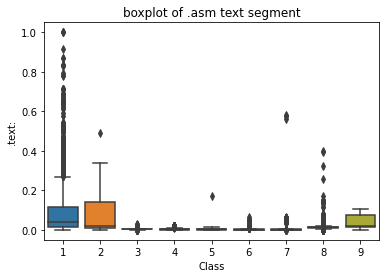

In [8]:
ax = sns.boxplot(x="Class", y=".text:", data=result_asm)
plt.title("boxplot of .asm text segment")
plt.show()

<pre>
The plot is between Text and class 
Class 1,2 and 9 can be easly separated
</pre>

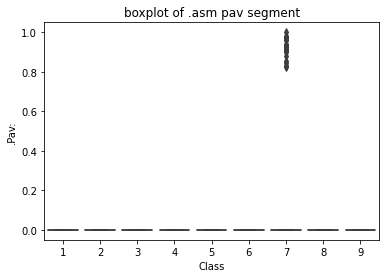

In [9]:
ax = sns.boxplot(x="Class", y=".Pav:", data=result_asm)
plt.title("boxplot of .asm pav segment")
plt.show()

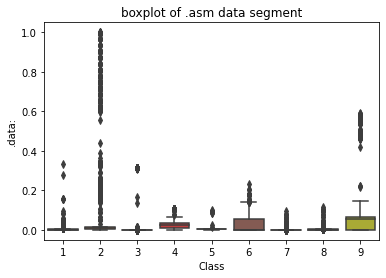

In [10]:
ax = sns.boxplot(x="Class", y=".data:", data=result_asm)
plt.title("boxplot of .asm data segment")
plt.show()

<pre>
The plot is between data segment and class label 
class 6 and class 9 can be easily separated from given points
</pre>

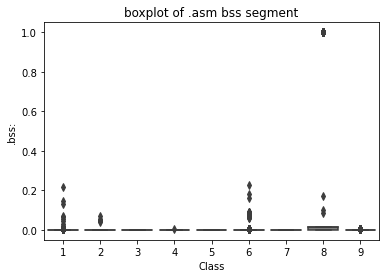

In [11]:
ax = sns.boxplot(x="Class", y=".bss:", data=result_asm)
plt.title("boxplot of .asm bss segment")
plt.show()

<pre>
plot between bss segment and class label
very less number of files are having bss segment
</pre>

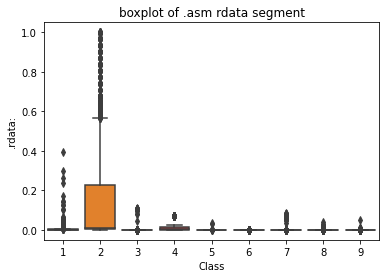

In [12]:
ax = sns.boxplot(x="Class", y=".rdata:", data=result_asm)
plt.title("boxplot of .asm rdata segment")
plt.show()

<pre>
Plot between rdata segment and Class segment
Class 2 can be easily separated 75 pecentile files are having 1M rdata lines
</pre>

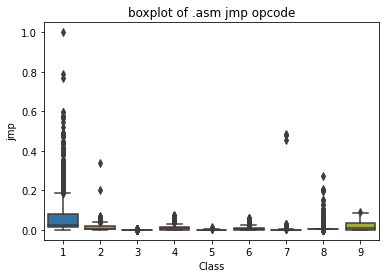

In [13]:
ax = sns.boxplot(x="Class", y="jmp", data=result_asm)
plt.title("boxplot of .asm jmp opcode")
plt.show()

<pre>
plot between jmp and Class label
Class 1 is having frequency of 2000 approx in 75 perentile of files
</pre>

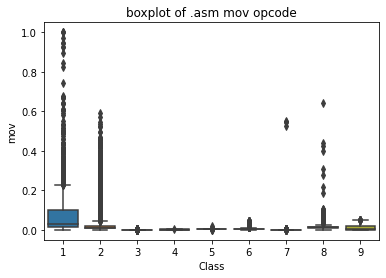

In [14]:
ax = sns.boxplot(x="Class", y="mov", data=result_asm)
plt.title("boxplot of .asm mov opcode")
plt.show()

<pre>
plot between Class label and mov opcode
Class 1 is having frequency of 2000 approx in 75 perentile of files
</pre>

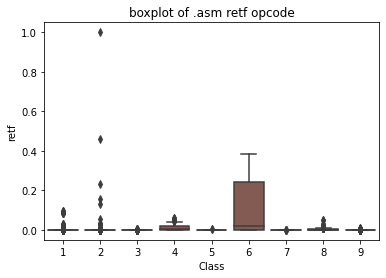

In [15]:
ax = sns.boxplot(x="Class", y="retf", data=result_asm)
plt.title("boxplot of .asm retf opcode")
plt.show()

<pre>
plot between Class label and retf
Class 6 can be easily separated with opcode retf
The frequency of retf is approx of 250.
</pre>

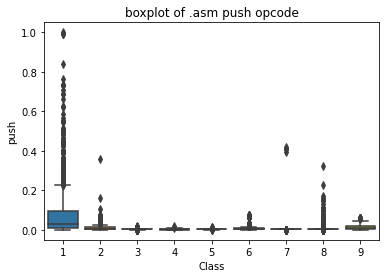

In [16]:
ax = sns.boxplot(x="Class", y="push", data=result_asm)
plt.title("boxplot of .asm push opcode")
plt.show()

<pre>
plot between push opcode and Class label
Class 1 is having 75 precentile files with push opcodes of frequency 1000
</pre>

<h2> 4.3 Train and test split</h2>

In [17]:
asm_y = result_asm['Class']
asm_x = result_asm.drop(['ID','Class','.BSS:','rtn','.CODE'], axis=1)

In [18]:
X_train_asm, X_test_asm, y_train_asm, y_test_asm = train_test_split(asm_x,asm_y ,stratify=asm_y,test_size=0.20)
X_train_asm, X_cv_asm, y_train_asm, y_cv_asm = train_test_split(X_train_asm, y_train_asm,stratify=y_train_asm,test_size=0.20)

In [19]:
print( X_cv_asm.isnull().all())

HEADER:    False
.text:     False
.Pav:      False
.idata:    False
.data:     False
.bss:      False
.rdata:    False
.edata:    False
.rsrc:     False
.tls:      False
.reloc:    False
jmp        False
mov        False
retf       False
push       False
pop        False
xor        False
retn       False
nop        False
sub        False
inc        False
dec        False
add        False
imul       False
xchg       False
or         False
shr        False
cmp        False
call       False
shl        False
ror        False
rol        False
jnb        False
jz         False
lea        False
movzx      False
.dll       False
std::      False
:dword     False
edx        False
esi        False
eax        False
ebx        False
ecx        False
edi        False
ebp        False
esp        False
eip        False
size       False
dtype: bool


In [20]:
#import pickle

#with open('asm_train_test_split.pickle', 'wb') as f:
    #pickle.dump([X_train_asm, X_test_asm, X_cv_asm, y_train_asm, y_test_asm, y_cv_asm], f)

In [2]:
import pickle

with open('asm_train_test_split.pickle', 'rb') as f:
    X_train_asm, X_test_asm, X_cv_asm, y_train_asm, y_test_asm, y_cv_asm = pickle.load(f)

<h2> 4.4. Machine Learning models on features of .asm files</h2>

<h3> 4.4.1 K-Nearest Neigbors </h3>

log_loss for k =  1 is 0.08782950533798942
log_loss for k =  3 is 0.08595409830345493
log_loss for k =  5 is 0.09685723489197808
log_loss for k =  7 is 0.10520580955084592
log_loss for k =  9 is 0.11224267418891457
log_loss for k =  11 is 0.1202890798551143
log_loss for k =  13 is 0.12818049977840545
log_loss for k =  15 is 0.1351074700719446
log_loss for k =  17 is 0.141908679697067
log_loss for k =  19 is 0.14905109128149108


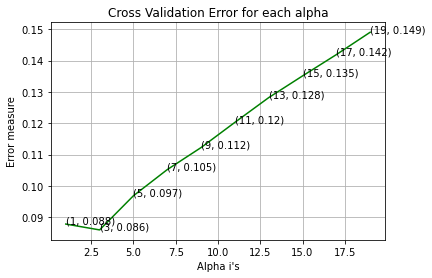

log loss for train data 0.050111714054146606
log loss for cv data 0.08595409830345493
log loss for test data 0.07130312042543031
Number of misclassified points  1.2419503219871204
-------------------------------------------------- Confusion matrix --------------------------------------------------


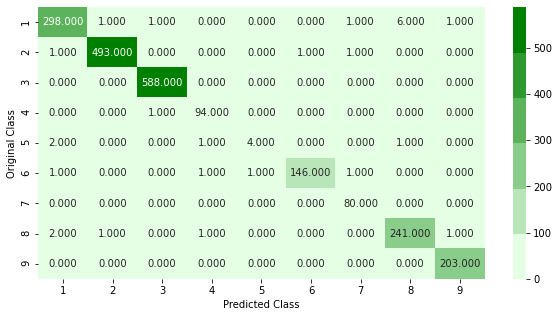

-------------------------------------------------- Precision matrix --------------------------------------------------


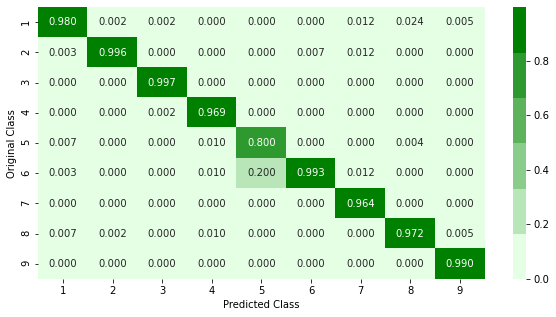

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


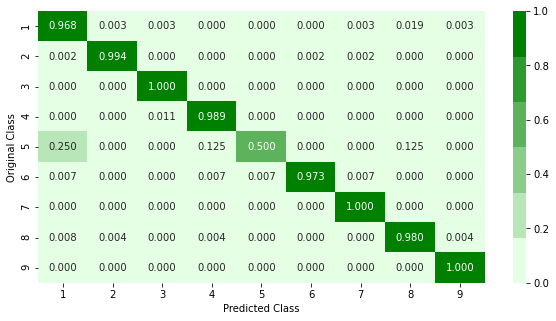

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [4]:
# find more about KNeighborsClassifier() here http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
# -------------------------
# default parameter
# KNeighborsClassifier(n_neighbors=5, weights=’uniform’, algorithm=’auto’, leaf_size=30, p=2, 
# metric=’minkowski’, metric_params=None, n_jobs=1, **kwargs)

# methods of
# fit(X, y) : Fit the model using X as training data and y as target values
# predict(X):Predict the class labels for the provided data
# predict_proba(X):Return probability estimates for the test data X.
#-------------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/k-nearest-neighbors-geometric-intuition-with-a-toy-example-1/
#-------------------------------------


# find more about CalibratedClassifierCV here at http://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
# ----------------------------
# default paramters
# sklearn.calibration.CalibratedClassifierCV(base_estimator=None, method=’sigmoid’, cv=3)
#
# some of the methods of CalibratedClassifierCV()
# fit(X, y[, sample_weight])	Fit the calibrated model
# get_params([deep])	Get parameters for this estimator.
# predict(X)	Predict the target of new samples.
# predict_proba(X)	Posterior probabilities of classification
#-------------------------------------
# video link:
#-------------------------------------

alpha = [x for x in range(1, 21,2)]
cv_log_error_array=[]
for i in alpha:
    k_cfl=KNeighborsClassifier(n_neighbors=i)
    k_cfl.fit(X_train_asm,y_train_asm)
    sig_clf = CalibratedClassifierCV(k_cfl, method="sigmoid")
    sig_clf.fit(X_train_asm, y_train_asm)
    predict_y = sig_clf.predict_proba(X_cv_asm)
    cv_log_error_array.append(log_loss(y_cv_asm, predict_y, labels=k_cfl.classes_, eps=1e-15))
    
for i in range(len(cv_log_error_array)):
    print ('log_loss for k = ',alpha[i],'is',cv_log_error_array[i])

best_alpha = np.argmin(cv_log_error_array)
    
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

k_cfl=KNeighborsClassifier(n_neighbors=alpha[best_alpha])
k_cfl.fit(X_train_asm,y_train_asm)
sig_clf = CalibratedClassifierCV(k_cfl, method="sigmoid")
sig_clf.fit(X_train_asm, y_train_asm)
pred_y=sig_clf.predict(X_test_asm)


predict_y = sig_clf.predict_proba(X_train_asm)
print ('log loss for train data',log_loss(y_train_asm, predict_y))
predict_y = sig_clf.predict_proba(X_cv_asm)
print ('log loss for cv data',log_loss(y_cv_asm, predict_y))
predict_y = sig_clf.predict_proba(X_test_asm)
print ('log loss for test data',log_loss(y_test_asm, predict_y))
plot_confusion_matrix(y_test_asm,sig_clf.predict(X_test_asm))

<h3> 4.4.2 Logistic Regression </h3>

log_loss for c =  1e-05 is 1.2894146635138855
log_loss for c =  0.0001 is 1.2891987681625565
log_loss for c =  0.001 is 1.2866542412242377
log_loss for c =  0.01 is 1.252867707312937
log_loss for c =  0.1 is 0.9716103044523192
log_loss for c =  1 is 1.1895962471066241
log_loss for c =  10 is 1.2492338121703404
log_loss for c =  100 is 1.1791766694826382
log_loss for c =  1000 is 1.1548743987805428


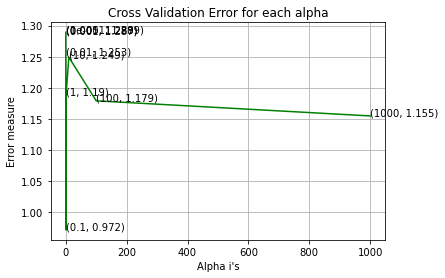

log loss for train data 0.9937187607595979
log loss for cv data 0.9716103044523192
log loss for test data 1.0021427033721062
Number of misclassified points  28.334866605335783
-------------------------------------------------- Confusion matrix --------------------------------------------------


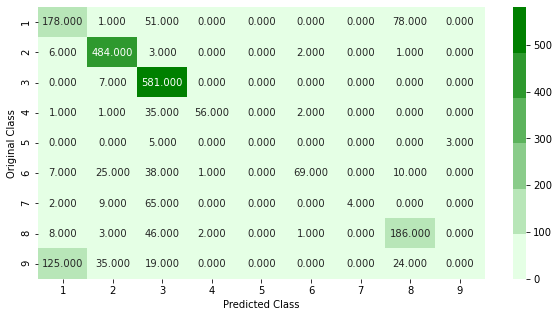

-------------------------------------------------- Precision matrix --------------------------------------------------


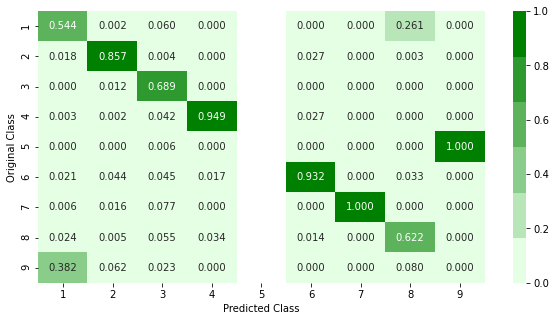

Sum of columns in precision matrix [ 1.  1.  1.  1. nan  1.  1.  1.  1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


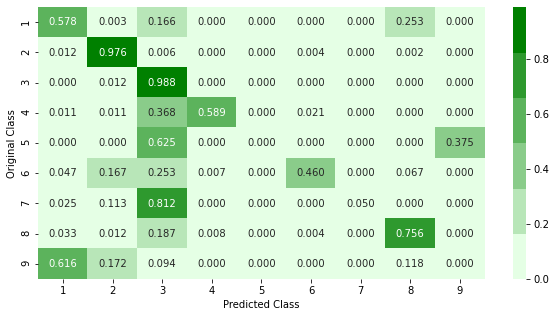

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [4]:
# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/geometric-intuition-1/
#------------------------------


alpha = [10 ** x for x in range(-5, 4)]
cv_log_error_array=[]
for i in alpha:
    logisticR=LogisticRegression(penalty='l2',C=i,class_weight='balanced')
    logisticR.fit(X_train_asm,y_train_asm)
    sig_clf = CalibratedClassifierCV(logisticR, method="sigmoid")
    sig_clf.fit(X_train_asm, y_train_asm)
    predict_y = sig_clf.predict_proba(X_cv_asm)
    cv_log_error_array.append(log_loss(y_cv_asm, predict_y, labels=logisticR.classes_, eps=1e-15))
    
for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])

best_alpha = np.argmin(cv_log_error_array)
    
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

logisticR=LogisticRegression(penalty='l2',C=alpha[best_alpha],class_weight='balanced')
logisticR.fit(X_train_asm,y_train_asm)
sig_clf = CalibratedClassifierCV(logisticR, method="sigmoid")
sig_clf.fit(X_train_asm, y_train_asm)

predict_y = sig_clf.predict_proba(X_train_asm)
print ('log loss for train data',(log_loss(y_train_asm, predict_y, labels=logisticR.classes_, eps=1e-15)))
predict_y = sig_clf.predict_proba(X_cv_asm)
print ('log loss for cv data',(log_loss(y_cv_asm, predict_y, labels=logisticR.classes_, eps=1e-15)))
predict_y = sig_clf.predict_proba(X_test_asm)
print ('log loss for test data',(log_loss(y_test_asm, predict_y, labels=logisticR.classes_, eps=1e-15)))
plot_confusion_matrix(y_test_asm,sig_clf.predict(X_test_asm))

<h3> 4.4.3 Random Forest Classifier</h3>

log_loss for c =  10 is 0.03979871161504338
log_loss for c =  50 is 0.03509558350496139
log_loss for c =  100 is 0.03479805592897491
log_loss for c =  500 is 0.03451678240698097
log_loss for c =  1000 is 0.034445041019581506
log_loss for c =  2000 is 0.03434882168084768
log_loss for c =  3000 is 0.03432525141920367


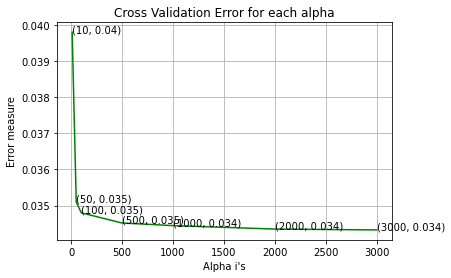

log loss for train data 0.016183986360706296
log loss for cv data 0.03432525141920367
log loss for test data 0.03079610791350603
Number of misclassified points  0.5059797608095675
-------------------------------------------------- Confusion matrix --------------------------------------------------


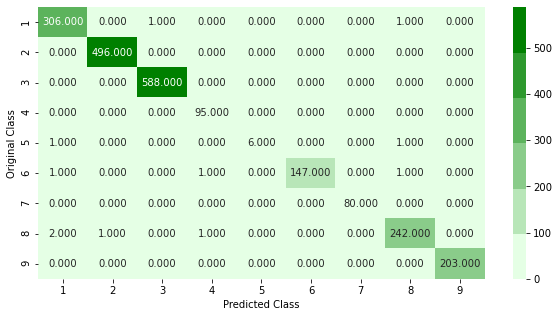

-------------------------------------------------- Precision matrix --------------------------------------------------


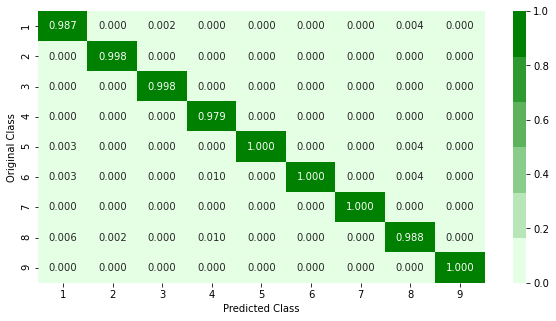

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


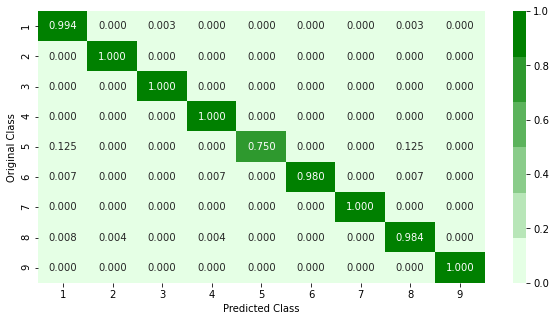

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [4]:
# --------------------------------
# default parameters 
# sklearn.ensemble.RandomForestClassifier(n_estimators=10, criterion=’gini’, max_depth=None, min_samples_split=2, 
# min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=’auto’, max_leaf_nodes=None, min_impurity_decrease=0.0, 
# min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=1, random_state=None, verbose=0, warm_start=False, 
# class_weight=None)

# Some of methods of RandomForestClassifier()
# fit(X, y, [sample_weight])	Fit the SVM model according to the given training data.
# predict(X)	Perform classification on samples in X.
# predict_proba (X)	Perform classification on samples in X.

# some of attributes of  RandomForestClassifier()
# feature_importances_ : array of shape = [n_features]
# The feature importances (the higher, the more important the feature).

# --------------------------------
# video link: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/random-forest-and-their-construction-2/
# --------------------------------

alpha=[10,50,100,500,1000,2000,3000]
cv_log_error_array=[]
for i in alpha:
    r_cfl=RandomForestClassifier(n_estimators=i,random_state=42,n_jobs=-1)
    r_cfl.fit(X_train_asm,y_train_asm)
    sig_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
    sig_clf.fit(X_train_asm, y_train_asm)
    predict_y = sig_clf.predict_proba(X_cv_asm)
    cv_log_error_array.append(log_loss(y_cv_asm, predict_y, labels=r_cfl.classes_, eps=1e-15))

for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])


best_alpha = np.argmin(cv_log_error_array)

fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

r_cfl=RandomForestClassifier(n_estimators=alpha[best_alpha],random_state=42,n_jobs=-1)
r_cfl.fit(X_train_asm,y_train_asm)
sig_clf = CalibratedClassifierCV(r_cfl, method="sigmoid")
sig_clf.fit(X_train_asm, y_train_asm)
predict_y = sig_clf.predict_proba(X_train_asm)
print ('log loss for train data',(log_loss(y_train_asm, predict_y, labels=sig_clf.classes_, eps=1e-15)))
predict_y = sig_clf.predict_proba(X_cv_asm)
print ('log loss for cv data',(log_loss(y_cv_asm, predict_y, labels=sig_clf.classes_, eps=1e-15)))
predict_y = sig_clf.predict_proba(X_test_asm)
print ('log loss for test data',(log_loss(y_test_asm, predict_y, labels=sig_clf.classes_, eps=1e-15)))
plot_confusion_matrix(y_test_asm,sig_clf.predict(X_test_asm))

<h3> 4.4.5 Xgboost Classifier with best hyperparameters</h3>

In [4]:
x_cfl=XGBClassifier()

prams={
    'learning_rate':[0.01,0.03,0.05,0.1,0.15,0.2],
     'n_estimators':[100,200,500,1000,2000],
     'max_depth':[3,5,10],
    'colsample_bytree':[0.1,0.3,0.5,1],
    'subsample':[0.1,0.3,0.5,1]
}
random_cfl=RandomizedSearchCV(x_cfl,param_distributions=prams,verbose=10,n_jobs=-1,)
random_cfl.fit(X_train_asm,y_train_asm)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   23.5s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:  3.1min remaining:   41.1s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:  3.4min remaining:   13.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.5min finished


RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_job...
                                           random_state=None, reg_alpha=None,
                                           reg_lambda=None,
                                           scale_pos_weight=No

In [5]:
print (random_cfl.best_params_)

{'subsample': 1, 'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.2, 'colsample_bytree': 0.5}


In [6]:
# Training a hyper-parameter tuned Xg-Boost regressor on our train data

# find more about XGBClassifier function here http://xgboost.readthedocs.io/en/latest/python/python_api.html?#xgboost.XGBClassifier
# -------------------------
# default paramters
# class xgboost.XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=100, silent=True, 
# objective='binary:logistic', booster='gbtree', n_jobs=1, nthread=None, gamma=0, min_child_weight=1, 
# max_delta_step=0, subsample=1, colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, 
# scale_pos_weight=1, base_score=0.5, random_state=0, seed=None, missing=None, **kwargs)

# some of methods of RandomForestRegressor()
# fit(X, y, sample_weight=None, eval_set=None, eval_metric=None, early_stopping_rounds=None, verbose=True, xgb_model=None)
# get_params([deep])	Get parameters for this estimator.
# predict(data, output_margin=False, ntree_limit=0) : Predict with data. NOTE: This function is not thread safe.
# get_score(importance_type='weight') -> get the feature importance
# -----------------------
# video link2: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/what-are-ensembles/
# -----------------------

x_cfl=XGBClassifier(n_estimators=200,subsample=0.5,learning_rate=0.15,colsample_bytree=0.5,max_depth=3)
x_cfl.fit(X_train_asm,y_train_asm)
c_cfl=CalibratedClassifierCV(x_cfl,method='sigmoid')
c_cfl.fit(X_train_asm,y_train_asm)

predict_y = c_cfl.predict_proba(X_train_asm)
print ('train loss',log_loss(y_train_asm, predict_y))
predict_y = c_cfl.predict_proba(X_cv_asm)
print ('cv loss',log_loss(y_cv_asm, predict_y))
predict_y = c_cfl.predict_proba(X_test_asm)
print ('test loss',log_loss(y_test_asm, predict_y))

train loss 0.013665993384002836
cv loss 0.026708347439082344
test loss 0.030006889442865853


<h2> 4.5. Machine Learning models on features of both .asm and .bytes files</h2>

In [1]:
import pandas as pd

In [2]:
import pickle

with open('Byte_Features_ID_Sparse.pickle', 'rb') as f:
    feature_matrix, ID_list = pickle.load(f)

In [3]:
feature_matrix_df = pd.DataFrame.sparse.from_spmatrix(feature_matrix)

In [4]:
feature_matrix_df['ID'] = ID_list

In [5]:
feature_matrix_df.head()

,0,1,2,3,4,5,6,7,8,9,...,66040,66041,66042,66043,66044,66045,66046,66047,66048,ID
0,17864.0,369.0,54.0,41.0,29.0,12.0,12.0,9.0,28.0,65.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1NSfFQ28b0TDh5YGnLeR
1,47034.0,782.0,885.0,226.0,277.0,117.0,72.0,128.0,210.0,194.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,bMzad2EXxSlq1ftBj5UK
2,9905.0,6.0,1.0,3.0,2.0,6.0,4.0,1.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8HEiC2mz6tVxPqD4QhlG
3,21430.0,423.0,169.0,88.0,152.0,36.0,25.0,13.0,49.0,24.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,hK7qMc3ZHmF5e4bLfCOj
4,3800.0,15.0,1.0,30.0,1.0,2.0,2.0,2.0,2.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5mTjuSpdDG8k1IBHaPqY


In [6]:
# asmoutputfile.csv(output genarated from the above two cells) will contain all the extracted features from .asm files
# this file will be uploaded in the drive, you can directly use this
dfasm=pd.read_csv("asmoutputfile.csv")
Y=pd.read_csv("trainLabels.csv")
Y.columns = ['ID', 'Class']
result_asm = pd.merge(dfasm, Y,on='ID', how='left')
result_asm.head()

,ID,HEADER:,.text:,.Pav:,.idata:,.data:,.bss:,.rdata:,.edata:,.rsrc:,...,edx,esi,eax,ebx,ecx,edi,ebp,esp,eip,Class
0,01kcPWA9K2BOxQeS5Rju,19,744,0,127,57,0,323,0,3,...,18,66,15,43,83,0,17,48,29,1
1,1E93CpP60RHFNiT5Qfvn,17,838,0,103,49,0,0,0,3,...,18,29,48,82,12,0,14,0,20,1
2,3ekVow2ajZHbTnBcsDfX,17,427,0,50,43,0,145,0,3,...,13,42,10,67,14,0,11,0,9,1
3,3X2nY7iQaPBIWDrAZqJe,17,227,0,43,19,0,0,0,3,...,6,8,14,7,2,0,8,0,6,1
4,46OZzdsSKDCFV8h7XWxf,17,402,0,59,170,0,0,0,3,...,12,9,18,29,5,0,11,0,11,1


In [7]:
X = pd.merge(feature_matrix_df, result_asm,on='ID', how='left')

In [8]:
X.head()

,0,1,2,3,4,5,6,7,8,9,...,edx,esi,eax,ebx,ecx,edi,ebp,esp,eip,Class
0,17864.0,369.0,54.0,41.0,29.0,12.0,12.0,9.0,28.0,65.0,...,395,557,592,1801,222,0,13,0,29,8
1,47034.0,782.0,885.0,226.0,277.0,117.0,72.0,128.0,210.0,194.0,...,4163,8770,4301,8885,9197,0,27,0,169,1
2,9905.0,6.0,1.0,3.0,2.0,6.0,4.0,1.0,2.0,2.0,...,155,149,140,152,263,0,35,0,54,6
3,21430.0,423.0,169.0,88.0,152.0,36.0,25.0,13.0,49.0,24.0,...,875,5246,1249,2609,5976,0,11,73,74,1
4,3800.0,15.0,1.0,30.0,1.0,2.0,2.0,2.0,2.0,3.0,...,37,39,123,81,1,0,4,0,0,7


In [9]:
Y = X['Class']

In [10]:
X = X.drop(['ID','rtn','.BSS:','.CODE','Class'], axis=1)

In [11]:
import pickle

#with open('X_Y.pickle', 'wb') as f:
    #pickle.dump([X, Y], f)

In [12]:
import pickle

with open('X_Y.pickle', 'rb') as f:
    X, Y = pickle.load(f)

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test_merge, y_train, y_test_merge = train_test_split(X, Y,stratify=Y,test_size=0.20)
X_train_merge, X_cv_merge, y_train_merge, y_cv_merge = train_test_split(X_train, y_train,stratify=y_train,test_size=0.20)

In [14]:
import pickle

with open('Final_Merged_Features-2.pickle', 'wb') as f:
    pickle.dump([X_train_merge, X_test_merge, X_cv_merge, y_train_merge, y_test_merge, y_cv_merge], f)

In [15]:
import pickle

#with open('Final_Merged_Features-2.pickle', 'rb') as f:
    #X_train_merge, X_test_merge, X_cv_merge, y_train_merge, y_test_merge, y_cv_merge = pickle.load(f)

<h3> 4.5.5. XgBoost Classifier on final features with best hyper parameters using Random search</h3>

In [4]:
x_cfl=XGBClassifier()

prams={
    'learning_rate':[0.01,0.03,0.05,0.1,0.15,0.2],
     'n_estimators':[100,200,500,1000,2000],
     'max_depth':[3,5,10],
    'colsample_bytree':[0.1,0.3,0.5,1],
    'subsample':[0.1,0.3,0.5,1]
}
random_cfl=RandomizedSearchCV(x_cfl,param_distributions=prams,verbose=10,n_jobs=-1,)
random_cfl.fit(X_train_merge[:100], y_train_merge[:100])

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 10.5min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 14.3min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 17.3min
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed: 21.5min remaining:  4.7min
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed: 22.7min remaining:  1.5min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 23.4min finished


RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_job...
                                           random_state=None, reg_alpha=None,
                                           reg_lambda=None,
                                           scale_pos_weight=No

In [5]:
print (random_cfl.best_params_)

{'subsample': 0.5, 'n_estimators': 1000, 'max_depth': 3, 'learning_rate': 0.03, 'colsample_bytree': 0.3}


<h3> 4.5.5. XgBoost Classifier on final features</h3>

The train log loss is: 0.012463118483338342
The cross validation log loss is: 0.0368014631463902
The test log loss is: 0.03967134597589798
Number of misclassified points  0.6439742410303588
-------------------------------------------------- Confusion matrix --------------------------------------------------


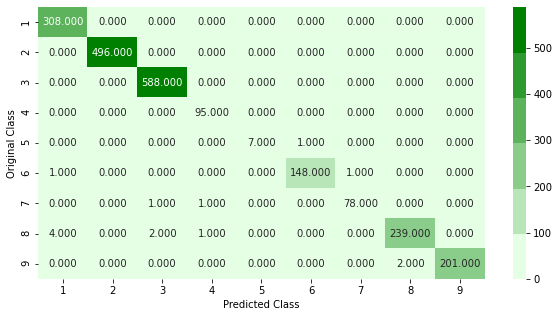

-------------------------------------------------- Precision matrix --------------------------------------------------


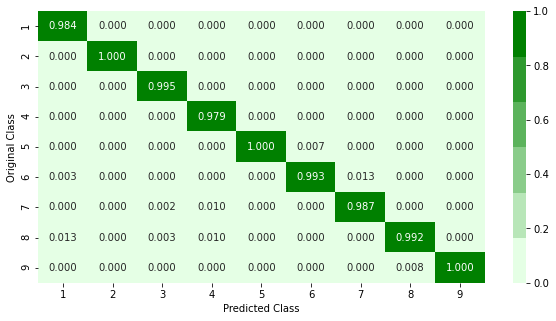

Sum of columns in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


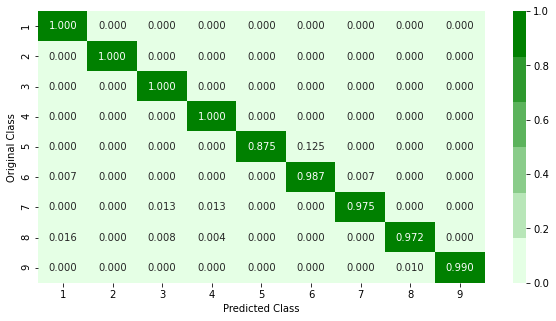

Sum of rows in precision matrix [1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [4]:

# find more about XGBClassifier function here http://xgboost.readthedocs.io/en/latest/python/python_api.html?#xgboost.XGBClassifier
# -------------------------
# default paramters
# class xgboost.XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=100, silent=True, 
# objective='binary:logistic', booster='gbtree', n_jobs=1, nthread=None, gamma=0, min_child_weight=1, 
# max_delta_step=0, subsample=1, colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, 
# scale_pos_weight=1, base_score=0.5, random_state=0, seed=None, missing=None, **kwargs)

# some of methods of RandomForestRegressor()
# fit(X, y, sample_weight=None, eval_set=None, eval_metric=None, early_stopping_rounds=None, verbose=True, xgb_model=None)
# get_params([deep])	Get parameters for this estimator.
# predict(data, output_margin=False, ntree_limit=0) : Predict with data. NOTE: This function is not thread safe.
# get_score(importance_type='weight') -> get the feature importance
# -----------------------
# video link2: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/what-are-ensembles/
# -----------------------

x_cfl=XGBClassifier(n_estimators=1000,max_depth=3,learning_rate=0.03,colsample_bytree=0.3,subsample=0.5,nthread=-1)
x_cfl.fit(X_train_merge, y_train_merge, verbose=True)
sig_clf = CalibratedClassifierCV(x_cfl, method="sigmoid")
sig_clf.fit(X_train_merge, y_train_merge)
    
predict_y = sig_clf.predict_proba(X_train_merge)
print("The train log loss is:",log_loss(y_train_merge, predict_y))
predict_y = sig_clf.predict_proba(X_cv_merge)
print("The cross validation log loss is:",log_loss(y_cv_merge, predict_y))
predict_y = sig_clf.predict_proba(X_test_merge)
print("The test log loss is:",log_loss(y_test_merge, predict_y))
plot_confusion_matrix(y_test_merge,sig_clf.predict(X_test_merge))

## Conclusion

Following are the results obtained for the Final combined features of both ASM and Byte files:
1. The train log loss is: 0.012463118483338342
2. The cross validation log loss is: 0.0368014631463902
3. The test log loss is: 0.03967134597589798
4. Number of misclassified points  0.6439742410303588

## Summary

By applying binary bag of words feature with n_grams = 2, the log loss has been drastically improved. Again both byte features and asm features are combined to get the improved result.